In [4]:
import os
import random
import torch
import torchvision.transforms as standard_transforms
import scipy.io as sio
import matplotlib
import pandas as pd
import misc.transforms as own_transforms
import warnings
import CCAugmentation as cca
import CCAugmentation.transformations as ccat

from torch.autograd import Variable
from torch.utils.data import DataLoader
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from tqdm import trange, tqdm
from misc.utils import *
from models.CC import CrowdCounter
from config import cfg
from datasets.SHHB.setting import cfg_data
from load_data import CustomDataset

torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True
warnings.filterwarnings('ignore')

In [8]:
model_path = './exp/12-07_15-54_SHHB_SCAR_1e-05/all_ep_250_mae_8.5_mse_14.5.pth'

net = CrowdCounter(cfg.GPU_ID,cfg.NET)
net.load_state_dict(torch.load(model_path))
net.cuda()
net.eval()

test_pipeline = cca.Pipeline(
        cca.examples.loading.SHHLoader("/dataset/ShanghaiTech", "test", "B"), [           
        ]
    ).execute_generate()
test_loader = DataLoader(CustomDataset(test_pipeline), batch_size=1, num_workers=1, drop_last=False)

test_img = list(test_loader)

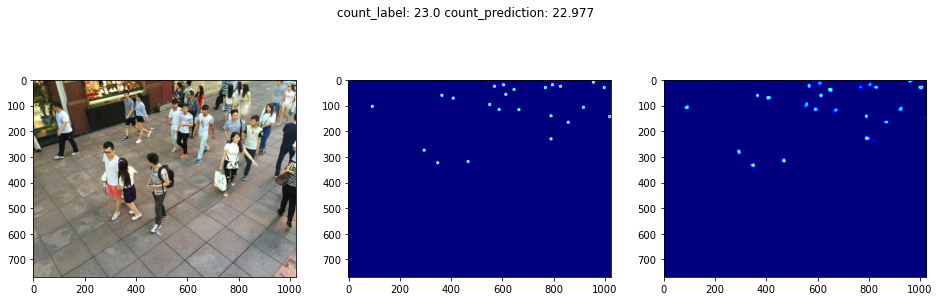

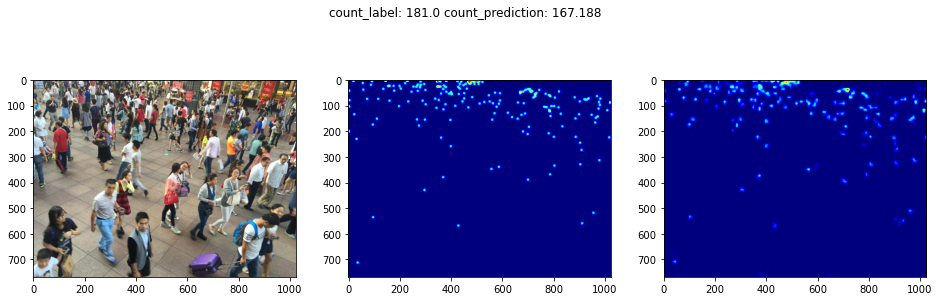

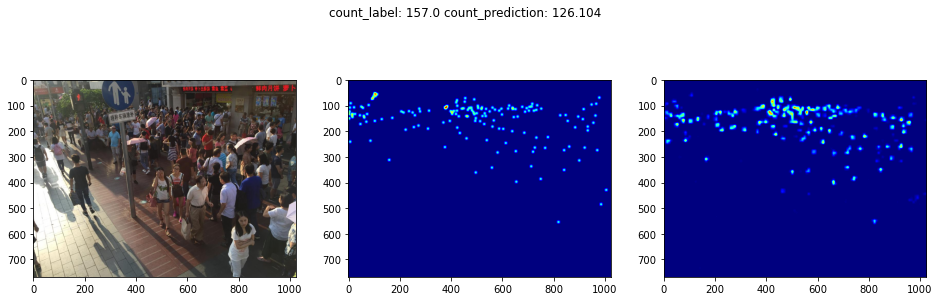

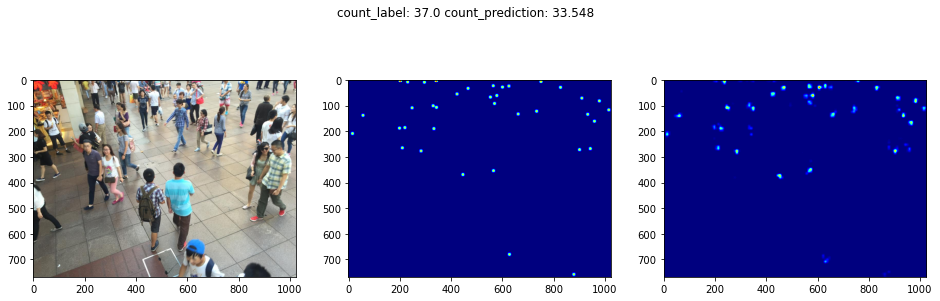

In [9]:
start = 0
N = 4

for vi, data in enumerate(test_img[start:start+N], 0):
    img, gt_map = data

    with torch.no_grad():
        img = Variable(img).cuda()
        pred_map = net.test_forward(img)
        pred_map = pred_map.data.cpu().numpy()
        
    new_img = img.data.cpu().numpy()
    new_img = np.moveaxis(new_img, 1, 2)
    new_img = np.moveaxis(new_img, 2, 3)
    new_img = np.squeeze(new_img)[:,:,::-1]
    
    pred_cnt = np.sum(pred_map[0])/100.0
    gt_count = np.sum(gt_map.data.cpu().numpy())/100.0
    
    fg, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
    plt.suptitle(' '.join([
            'count_label:', str(round(gt_count, 3)),
            'count_prediction:', str(round(pred_cnt, 3))
        ]))
    ax0.imshow(np.uint8(new_img))
    ax1.imshow(np.squeeze(gt_map), cmap='jet')
    ax2.imshow(np.squeeze(pred_map), cmap='jet')
    plt.show()

In [10]:
mae = np.empty(len(test_img))
mse = np.empty(len(test_img))
for vi, data in enumerate(tqdm(test_img), 0):
    img, gt_map = data

    with torch.no_grad():
        img = Variable(img).cuda()
        pred_map = net.test_forward(img)
        pred_map = pred_map.data.cpu().numpy()
    
    pred_cnt = np.sum(pred_map[0])/100.0
    gt_count = np.sum(gt_map.data.cpu().numpy())/100.0
    mae[vi] = np.abs(gt_count-pred_cnt)
    mse[vi] = (gt_count-pred_cnt)**2
    
print('MAE:', round(mae.mean(),2))
print('MSE:', round(np.sqrt(mse.mean()),2))

100%|██████████| 316/316 [00:37<00:00,  8.50it/s]

MAE: 8.79
MSE: 14.45
